<a href="https://colab.research.google.com/github/snpsuen/Deep_Learning_Notebook_Modelling/blob/main/notebook/MLP_ofdm_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt

# Divide a bit stream into 4-bit parallel groups
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))

# Map an array of parallel bit groups into another array of the mapped 16-QAM constellation points
def Mapping(parallelbits):
    return np.array([mapping_table[tuple(pb)] for pb in parallelbits])

# Assign the the mapped QAM constellation points and pilot points to an array indexed by the sub-carriers
def OFDM_Carriers(QAM, pilot):
    ofdm_sym = np.zeros(K, dtype=complex) # the overall K subcarriers
    ofdm_sym[pilotCarriers] = pilot  # allocate the pilot subcarriers
    ofdm_sym[dataCarriers] = QAM  # allocate the data subcarriers
    return ofdm_sym

def IDFT(frequency_weights):
    return np.fft.ifft(frequency_weights)

def prependCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning

def prependCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning

def transmit(signal):
    convolution = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolution**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolution.shape)+1j*np.random.randn(*convolution.shape))

    return convolution + noise

def removeCP(signal):
    return signal[CP:(CP+K)]

def DFT(OFDM_intime):
    return np.fft.fft(OFDM_intime)

def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest

# Map the QAM raw data received to the closest constellation points
def constellate(QAM_raw):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    QAM_approx = np.zeros((55,), dtype=complex)

    for i in range(len(QAM_raw)):
      start = 1
      for m in range(len(constellation)):
        dist = abs(QAM_raw[i] - constellation[m])
        if start == 1:
          min = dist
          QAM_approx[i] = constellation[m]
          start = 0
        elif dist < min:
          min = dist
          QAM_approx[i] = constellation[m]

    return QAM_approx

def PS(bits):
    return bits.reshape((-1,))


allCarriers:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
pilotCarriers: [ 0  8 16 24 32 40 48 56 63]
dataCarriers:  [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54
 55 57 58 59 60 61 62]
Number of all carriers:  64
Number of data carriers:  55
Number of pilot carriers:  9


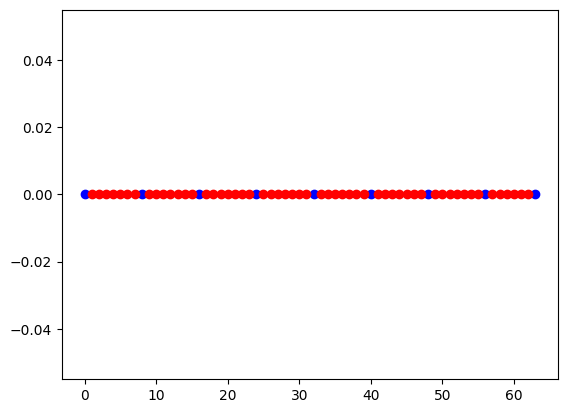

In [58]:
K = 64 # number of OFDM subcarriers
CP = K//4  # length of the cyclic prefix: 25% of the block
P = 8 # number of pilot carriers per OFDM block
pilotValue = 3+3j # The known value each pilot transmits

allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)
D = len(dataCarriers)

print ("allCarriers:   %s" % allCarriers)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)
print("Number of all carriers: ", len(allCarriers))
print("Number of data carriers: ", len(dataCarriers))
print("Number of pilot carriers: ", len(pilotCarriers))

plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')

Number of payload bits in an OFDM symbol:  220


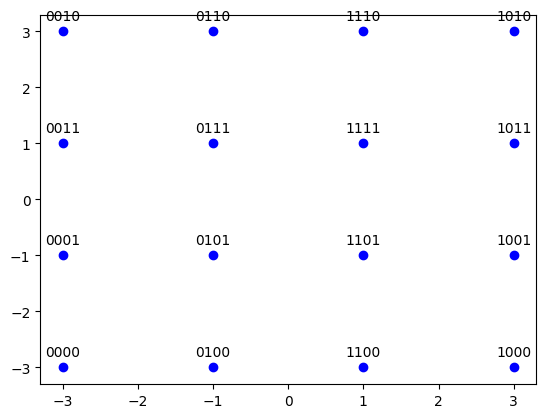

In [59]:
mu = 4 # bits per symbol (i.e. 16QAM)
payloadsize = len(dataCarriers)*mu  # number of payload bits per OFDM symbol
print("Number of payload bits in an OFDM symbol: ", payloadsize)

mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}

demapping_table = {v : k for k, v in mapping_table.items()}

for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

channelResponse shape:  (64,)


Text(0, 0.5, '$|cir(t)|$')

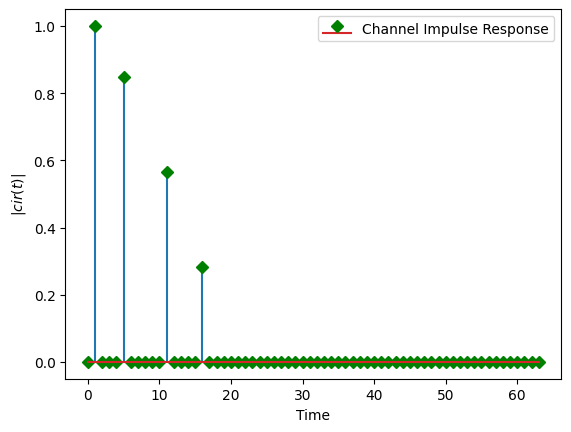

In [60]:
channelResponse = np.zeros((64,), dtype=complex)
channelResponse[1] = 1
channelResponse[5] = 0.6 + 0.6j
channelResponse[11] = 0.4 + 0.4j
channelResponse[16] = 0.2 + 0.2j

#channelResponse = np.array([1, 0, 0.3+0.3j])
print ("channelResponse shape: ", channelResponse.shape)
# channelResponse = np.array([1, 0, 0, 0.2+0.2j])  # the impulse response of the wireless channel
timeline = np.arange(64)
plt.stem(timeline, abs(channelResponse), markerfmt='gD', label='Channel Impulse Response')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|cir(t)|$')

Hf_CIR shape:  (64,)
Hf_CIR:  [ 2.20000000e+00+1.2j         2.54850273e+00-0.21591223j
  1.72336894e+00-1.11544589j  9.75580709e-01-0.98745226j
  9.25972007e-01-0.75014277j  9.43304095e-01-0.95287748j
  6.30402878e-01-1.14681761j  3.23565451e-01-1.10104894j
  5.85786438e-02-1.07279221j -4.12831729e-01-0.83967932j
 -5.86196983e-01-0.01166627j  2.43673303e-01+0.72548247j
  1.43002628e+00+0.27653669j  1.58348654e+00-0.97750682j
  7.16954477e-01-1.57006159j  1.68680741e-01-1.20570925j
  4.00000000e-01-1.j          5.12507387e-01-1.46584833j
 -5.81401146e-03-1.90264944j -6.69718195e-01-1.8501422j
 -1.18309965e+00-1.57122238j -1.67880047e+00-1.05419783j
 -1.77537358e+00-0.0897024j  -9.67724416e-01+0.67421456j
  5.85786438e-02+0.34142136j  9.36452051e-02-0.58494828j
 -6.40222234e-01-0.7545035j  -8.00440517e-01-0.13277957j
 -1.56420194e-01+0.01522409j  1.40227251e-01-0.70892505j
 -4.60429715e-01-1.33767398j -1.27728963e+00-1.25133514j
 -1.80000000e+00-0.8j        -2.14850273e+00-0.18408777j
 -

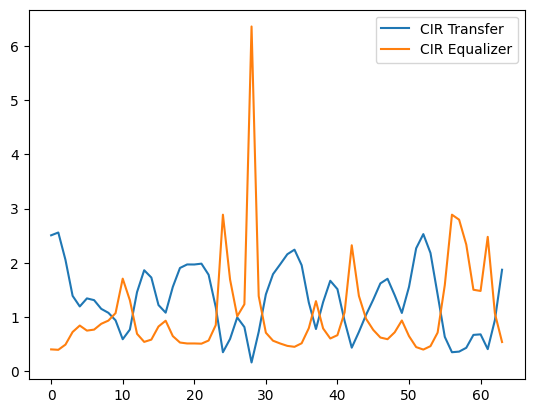

In [61]:
Hf_CIR = np.fft.fft(channelResponse, K)
Eq_CIR = np.reciprocal(Hf_CIR)
plt.plot(allCarriers, abs(Hf_CIR), label='CIR Transfer')
plt.plot(allCarriers, abs(Eq_CIR), label='CIR Equalizer')
plt.legend()

SNRdb = 25  # signal to noise-ratio in dB at the receiver
print ("Hf_CIR shape: ", Hf_CIR.shape)
print ("Hf_CIR: ", Hf_CIR)

In [62]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

def create_learning_data(sampleize, testingsize):
  for i in range(sampleize):
    bits = np.random.binomial(n=1, p=0.5, size=payloadsize)
    SP_bits = SP(bits)
    QAM_payload = Mapping(SP_bits)
    OFDM_symbol = OFDM_Carriers(QAM_payload, pilotValue)
    OFDM_time = IDFT(OFDM_symbol)
    CP_OFDM_time = prependCP(OFDM_time)

    OFDM_RX = transmit(CP_OFDM_time)
    OFDM_RX_stripped = removeCP(OFDM_RX)
    OFDM_demod = DFT(OFDM_RX_stripped)

    pilot_output = OFDM_demod[pilotCarriers]
    H_pilot = pilot_output/pilotValue
    H_known = OFDM_demod/OFDM_symbol

    if i == 0:
      X = H_pilot.reshape(1,P)
      Y = H_known.reshape(1,K)
    else:
      X = np.append(X, H_pilot.reshape(1,P), axis=0)
      Y = np.append(Y, H_known.reshape(1,K), axis=0)

  X_training, X_testing = X[:-testingsize], X[-testingsize:]
  Y_training, Y_testing = Y[:-testingsize], Y[-testingsize:]

  return X_training, X_testing, Y_training, Y_testing

sampleize = 100
testingsize = 20
X_training, X_testing, Y_training, Y_testing = create_learning_data(sampleize, testingsize)
print("X_training.shape: ", X_training.shape)
print("Y_training.shape: ", Y_training.shape)
print("X_testing.shape: ", X_testing.shape)
print("Y_testing.shape: ", Y_testing.shape)

X_training.shape:  (80, 9)
Y_training.shape:  (80, 64)
X_testing.shape:  (20, 9)
Y_testing.shape:  (20, 64)


In [80]:
def MLP_modeling(X_training, Y_training, X_testing, Y_testing):
  input_dim = X_training.shape[1]
  output_dim = Y_training.shape[1]
  model = Sequential()
  # model.add(Dense(256, activation='relu', kernel_initializer='he_normal', input_dim=input_dim)) # input input_dim (9) -> output 256
  # model.add(Dense(128, activation='relu', kernel_initializer='he_normal')) # input 256 -> output 128
  model.add(Dense(128, activation='relu', kernel_initializer='he_normal', input_dim=input_dim)) # input input_dim (9) -> output 128
  model.add(Dense(output_dim)) # input 128 -> output output_dim (64)
  model.summary()

  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  # fit the model
  model.fit(X_training, Y_training, epochs=100, batch_size=16, verbose=2, validation_data=(X_testing, Y_testing))

  mse, mae = model.evaluate(X_testing, Y_testing, verbose=0)
  print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))
  return model

RX_training, IX_training = X_training.real, X_training.imag
RX_testing, IX_testing = X_testing.real, X_testing.imag
RY_training, IY_training = Y_training.real, Y_training.imag
RY_testing, IY_testing = Y_testing.real, Y_testing.imag

rofdm_model = MLP_modeling(RX_training, RY_training, RX_testing, RY_testing)
iofdm_model = MLP_modeling(IX_training, IY_training, IX_testing, IY_testing)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               1280      
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
Total params: 9536 (37.25 KB)
Trainable params: 9536 (37.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
5/5 - 1s - loss: 1.7998 - mae: 1.1053 - val_loss: 1.3423 - val_mae: 0.9019 - 849ms/epoch - 170ms/step
Epoch 2/100
5/5 - 0s - loss: 1.1150 - mae: 0.7942 - val_loss: 0.8118 - val_mae: 0.6412 - 40ms/epoch - 8ms/step
Epoch 3/100
5/5 - 0s - loss: 0.6667 - mae: 0.5569 - val_loss: 0.4765 - val_mae: 0.4413 - 37ms/epoch - 7ms/step
Epoch 4/100
5/5 - 0s - loss: 0.3894 - mae: 0.3845 - val_loss: 0.2784 - val_mae: 

In [81]:
bits = np.random.binomial(n=1, p=0.5, size=payloadsize)
print ("Bits count: ", len(bits))
print ("First 20 bits: ", bits[:50])
print ("Mean of bits (should be around 0.5): ", np.mean(bits))

Bits count:  220
First 20 bits:  [0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0
 1 1 1 0 0 1 0 0 1 0 0 0 0]
Mean of bits (should be around 0.5):  0.4818181818181818


In [82]:
SP_bits = SP(bits)
print ("SP_bits length: ", len(SP_bits))
print ("First 10 bit groups")
print (SP_bits[:10,:])

SP_bits length:  55
First 10 bit groups
[[0 1 1 0]
 [1 0 1 0]
 [0 0 1 1]
 [0 0 0 0]
 [1 0 1 1]
 [1 1 1 0]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 0 1]
 [0 1 1 1]]


In [83]:
QAM_payload = Mapping(SP_bits)
print ("QAM_payload array length: ", len(QAM_payload))
print ("QAM_payload element type: ", QAM_payload.dtype)
print ("First 8 QAM_payload symbols and bits:")
print (SP_bits[:8,:])
print (QAM_payload[:8])

QAM_payload array length:  55
QAM_payload element type:  complex128
First 8 QAM_payload symbols and bits:
[[0 1 1 0]
 [1 0 1 0]
 [0 0 1 1]
 [0 0 0 0]
 [1 0 1 1]
 [1 1 1 0]
 [0 1 0 0]
 [0 1 0 1]]
[-1.+3.j  3.+3.j -3.+1.j -3.-3.j  3.+1.j  1.+3.j -1.-3.j -1.-1.j]


In [84]:
OFDM_symbol = OFDM_Carriers(QAM_payload, pilotValue)
print ("ODFM_symbol shape: ", OFDM_symbol.shape)
print ("ODFM_symbol array length: ", len(OFDM_symbol))
print ("ODMF_symbol element type: ", OFDM_symbol.dtype)

ODFM_symbol shape:  (64,)
ODFM_symbol array length:  64
ODMF_symbol element type:  complex128


In [85]:
OFDM_time = IDFT(OFDM_symbol)
print ("OFDM_time shape: ", OFDM_time.shape)
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))

OFDM_time shape:  (64,)
Number of OFDM samples in time-domain before CP:  64


In [86]:
CP_OFDM_time = prependCP(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(CP_OFDM_time))

Number of OFDM samples in time domain with CP:  80


Number of received OFDM_RX samples in time domain:  143


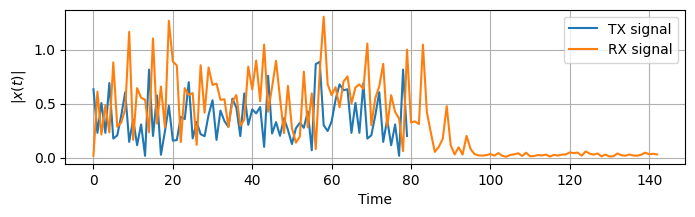

In [87]:
OFDM_TX = CP_OFDM_time
OFDM_RX = transmit(OFDM_TX)
print ("Number of received OFDM_RX samples in time domain: ", len(OFDM_RX))
plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
plt.grid(True);

In [88]:
OFDM_RX_stripped = removeCP(OFDM_RX)
print ("Number of received OFDM_RX_stripped samples in time domain: ", len(OFDM_RX_stripped))

Number of received OFDM_RX_stripped samples in time domain:  64


In [89]:
OFDM_demod = DFT(OFDM_RX_stripped)
print ("OFDM_demod shape: ", OFDM_demod.shape)
print ("Number of OFDM_infreq samples in frequency domain: ", len(OFDM_demod))

pilot_output = OFDM_demod[pilotCarriers]
H_pilot = pilot_output/pilotValue
print ("H_pilot.shape: ", H_pilot.shape)

OFDM_demod shape:  (64,)
Number of OFDM_infreq samples in frequency domain:  64
H_pilot.shape:  (9,)


In [90]:
RH_pilot = H_pilot.real.reshape(1, P)
IH_pilot = H_pilot.imag.reshape(1, P)
print("RH_pilot.shape: ", RH_pilot.shape)
print("IH_pilot.shape: ", IH_pilot.shape)

RH_predict = rofdm_model.predict(RH_pilot)
IH_predict = iofdm_model.predict(IH_pilot)
print("RH_predict.shape: ", RH_predict.shape)
print("RH_predict: ", RH_predict)
print("IH_predict.shape: ", IH_predict.shape)
print("IH_predict: ", IH_predict)

RH_pilot.shape:  (1, 9)
IH_pilot.shape:  (1, 9)
1/1 [==============================] - 0s 48ms/step
RH_predict.shape:  (1, 64)
RH_predict:  [[ 2.2268715   2.5910797   1.7568109   0.96766907  0.9241238   0.9801806
   0.69078094  0.3623949   0.06581725 -0.41174427 -0.58474255  0.29621592
   1.4589928   1.6452514   0.73574495  0.17530957  0.4276086   0.51492274
  -0.00820952 -0.6771563  -1.1834002  -1.7136971  -1.7557958  -1.0068297
   0.04057584  0.10245989 -0.65692484 -0.7963272  -0.17870924  0.11703172
  -0.47694886 -1.2654281  -1.8004194  -2.19541    -2.1367083  -1.4135779
  -0.5718582  -0.52601814 -1.0817308  -0.72410494  0.35575512  0.8112156
   0.21546707 -0.6746423  -1.029508   -1.1734115  -1.1362649  -0.58703136
  -0.03499313 -0.11331019 -0.3715456   0.3098479   1.5991999   2.102562
   1.4118618   0.6182984   0.34962618  0.3165871   0.23705228  0.4065329
   0.5709157   0.25920382  0.05472388  0.8986032 ]]
IH_predict.shape:  (1, 64)
IH_predict:  [[ 1.2302911  -0.27674294 -1.134743

In [91]:
RH_predict = RH_predict.reshape(K,)
IH_predict = IH_predict.reshape(K,)
H_predict = RH_predict + 1j*IH_predict
print("H_predict.shape: ", H_predict.shape)
print("H_predict: ", H_predict)

equalized_H_predict = equalize(OFDM_demod, H_predict)
print("equalized_H_predict.shape: ", equalized_H_predict.shape)
print("equalized_H_predict: ", equalized_H_predict)

H_predict.shape:  (64,)
H_predict:  [ 2.2268715 +1.2302911j   2.5910797 -0.27674294j  1.7568109 -1.1347432j
  0.96766907-1.1059403j   0.9241238 -0.8181377j   0.9801806 -0.94252956j
  0.69078094-1.184879j    0.3623949 -1.115229j    0.06581725-1.1327355j
 -0.41174427-0.8134032j  -0.58474255+0.01679842j  0.29621592+0.7640363j
  1.4589928 +0.30745548j  1.6452514 -1.0520567j   0.73574495-1.7012211j
  0.17530957-1.2273513j   0.4276086 -1.0194418j   0.51492274-1.514986j
 -0.00820952-1.9327747j  -0.6771563 -1.8865254j  -1.1834002 -1.5188714j
 -1.7136971 -0.9585122j  -1.7557958 -0.1265615j  -1.0068297 +0.6126007j
  0.04057584+0.321491j    0.10245989-0.5597485j  -0.65692484-0.7311668j
 -0.7963272 -0.05622218j -0.17870924+0.09055064j  0.11703172-0.6952566j
 -0.47694886-1.3675861j  -1.2654281 -1.3036788j  -1.8004194 -0.9029214j
 -2.19541   -0.13883726j -2.1367083 +0.77741724j -1.4135779 +1.3997691j
 -0.5718582 +1.1530523j  -0.52601814+0.5672665j  -1.0817308 +0.68088984j
 -0.72410494+1.5188289j   0

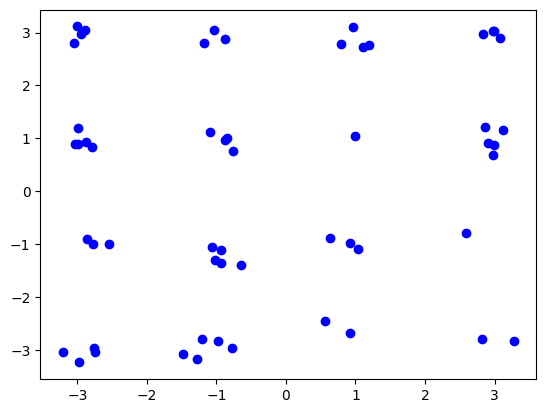

In [92]:
QAM_predict = equalized_H_predict[dataCarriers]
plt.plot(QAM_predict.real, QAM_predict.imag, 'bo');

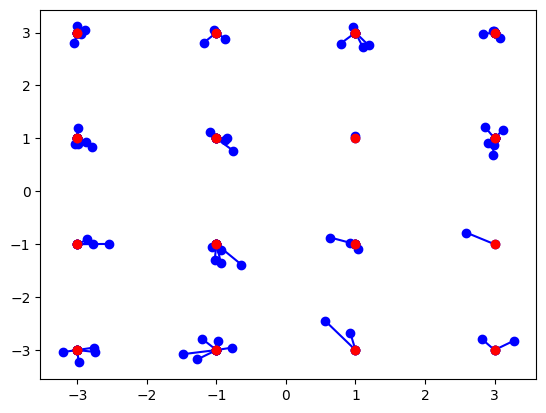

In [93]:
QAM_constell = constellate(QAM_predict)
PS_predict = np.vstack([demapping_table[c] for c in QAM_constell])

for pre, con in zip(QAM_predict, QAM_constell):
    plt.plot([pre.real, con.real], [pre.imag, con.imag], 'b-o');
    plt.plot(con.real, con.imag, 'ro')

In [94]:
bits_predict = PS(PS_predict)
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_predict))/len(bits))
print("1. First 100 bits of bits:")
print(bits[:100])
print("2. First 100 bits of bits_predict:")
print(bits_predict[:100])

Obtained Bit error rate:  0.0
1. First 100 bits of bits:
[0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0
 1 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1
 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1]
2. First 100 bits of bits_predict:
[0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0
 1 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1
 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1]


pilots shape:  (9,)
pilots :  [ 2.7849175 +10.18442344j  3.71994092 -3.11380567j
  4.19726996 -1.88072745j -0.46662233 +0.95238593j
 -2.81323972 -7.61370858j -3.32639307 +5.53709823j
 -4.25724658 +4.25860055j  0.93303204 +1.26048031j
 -2.20176743 +7.55736473j]
Hest_at_pilots shape:  (9,)
Hest_at_pilots :  [ 2.16155682e+00+1.23325099j  1.01022541e-01-1.13895777j
  3.86090419e-01-1.01299957j  8.09606009e-02+0.23650138j
 -1.73782472e+00-0.80007814j  3.68450861e-01+1.47724855j
  2.25661486e-04+1.41930786j  3.65585392e-01+0.05457471j
  8.92599550e-01+1.62652203j]
HfCIR_at_pilots shape:  (9,)
HfCIR_at_pilots :  [ 2.20000000e+00+1.2j         5.85786438e-02-1.07279221j
  4.00000000e-01-1.j          5.85786438e-02+0.34142136j
 -1.80000000e+00-0.8j         3.41421356e-01+1.47279221j
  5.55111512e-17+1.4j         3.41421356e-01+0.05857864j
  8.77289632e-01+1.65133514j]
Hest shape:  (64,)


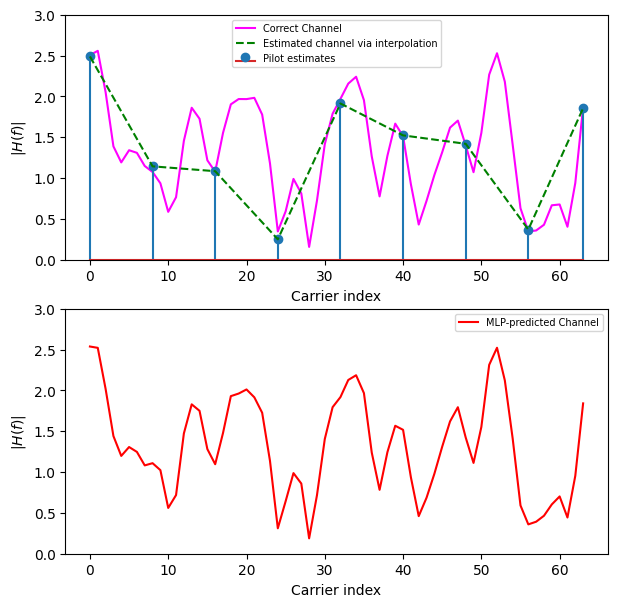

In [79]:
import scipy
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    # OFDM_demod[f] = Hest[f] * OFDM_symbol[f]
    # OFDM_dmod[pilotCarriers] = Hest[pilotCarriers] * OFDM_symbol[pilotCarriers]
    # OFDM_dmod[pilotCarriers] = Hest[pilotCarriers] * pilotValue
    # Hest[pilotCarriers] = OFDM_dmod[pilotCarriers] / pilotValue

    Hest_at_pilots = OFDM_demod[pilotCarriers] / pilotValue # divide by the transmitted pilot values
    HfCIR_at_pilots = Hf_CIR[pilotCarriers]

    print("pilots shape: ", pilots.shape)
    print("pilots : ", pilots)
    print("Hest_at_pilots shape: ", Hest_at_pilots.shape)
    print("Hest_at_pilots : ", Hest_at_pilots)
    print("HfCIR_at_pilots shape: ", HfCIR_at_pilots.shape)
    print("HfCIR_at_pilots : ", HfCIR_at_pilots)

    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)

    plt.figure(figsize=(7,7))
    plt.subplot(2, 1, 1)
    plt.plot(allCarriers, abs(Hf_CIR), color='magenta', label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), 'g--', label='Estimated channel via interpolation')
    # plt.grid(True);
    plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=7)
    plt.ylim(0,3)

    plt.subplot(2, 1, 2)
    plt.plot(allCarriers, abs(H_predict), color='red', label='MLP-predicted Channel')
    # plt.grid(True);
    plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=7)
    plt.ylim(0,3)

    return Hest

Hest = channelEstimate(OFDM_demod)
print ("Hest shape: ", Hest.shape)